In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
df= pd.read_csv("PJME_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
print(df.head())


                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0


In [3]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

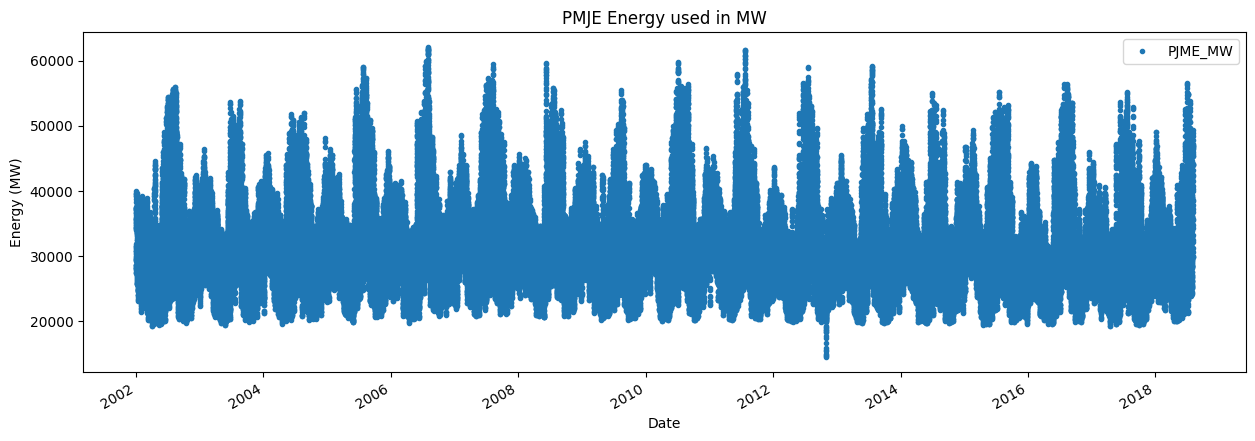

In [4]:
color_pal=sns.color_palette()
ax = df.plot(style='.', figsize=(15, 5), color=color_pal, title='PMJE Energy used in MW')

# Add axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')

# Show the plot
plt.show()

<Axes: ylabel='Frequency'>

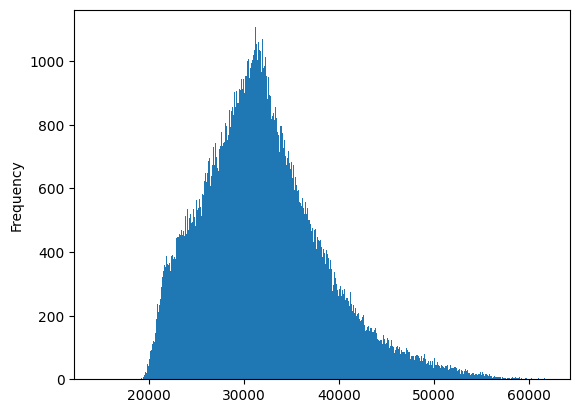

In [5]:
df['PJME_MW'].plot(kind='hist',bins=500)

<Axes: xlabel='Datetime'>

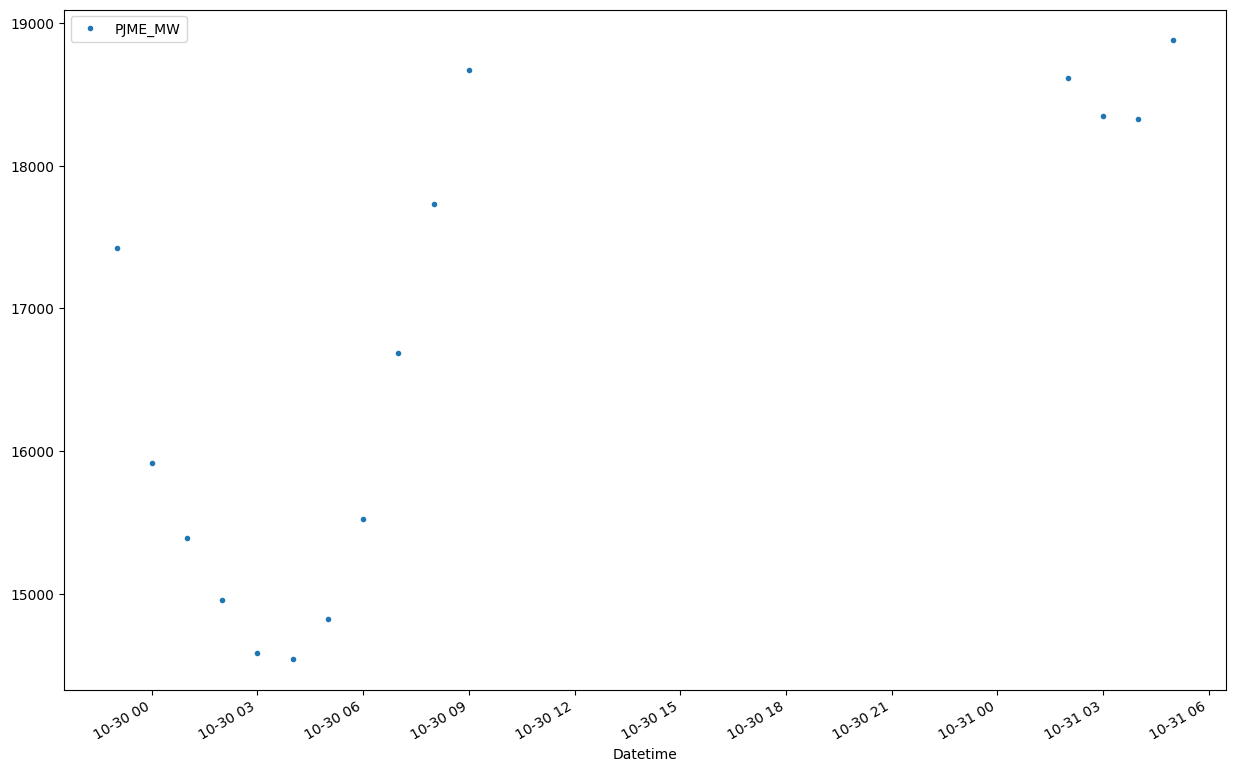

In [6]:
df.query('PJME_MW < 19000').plot(figsize=(15,10), style='.')

In [7]:
from sklearn.model_selection import TimeSeriesSplit

In [8]:
tss= TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df=df.sort_index()

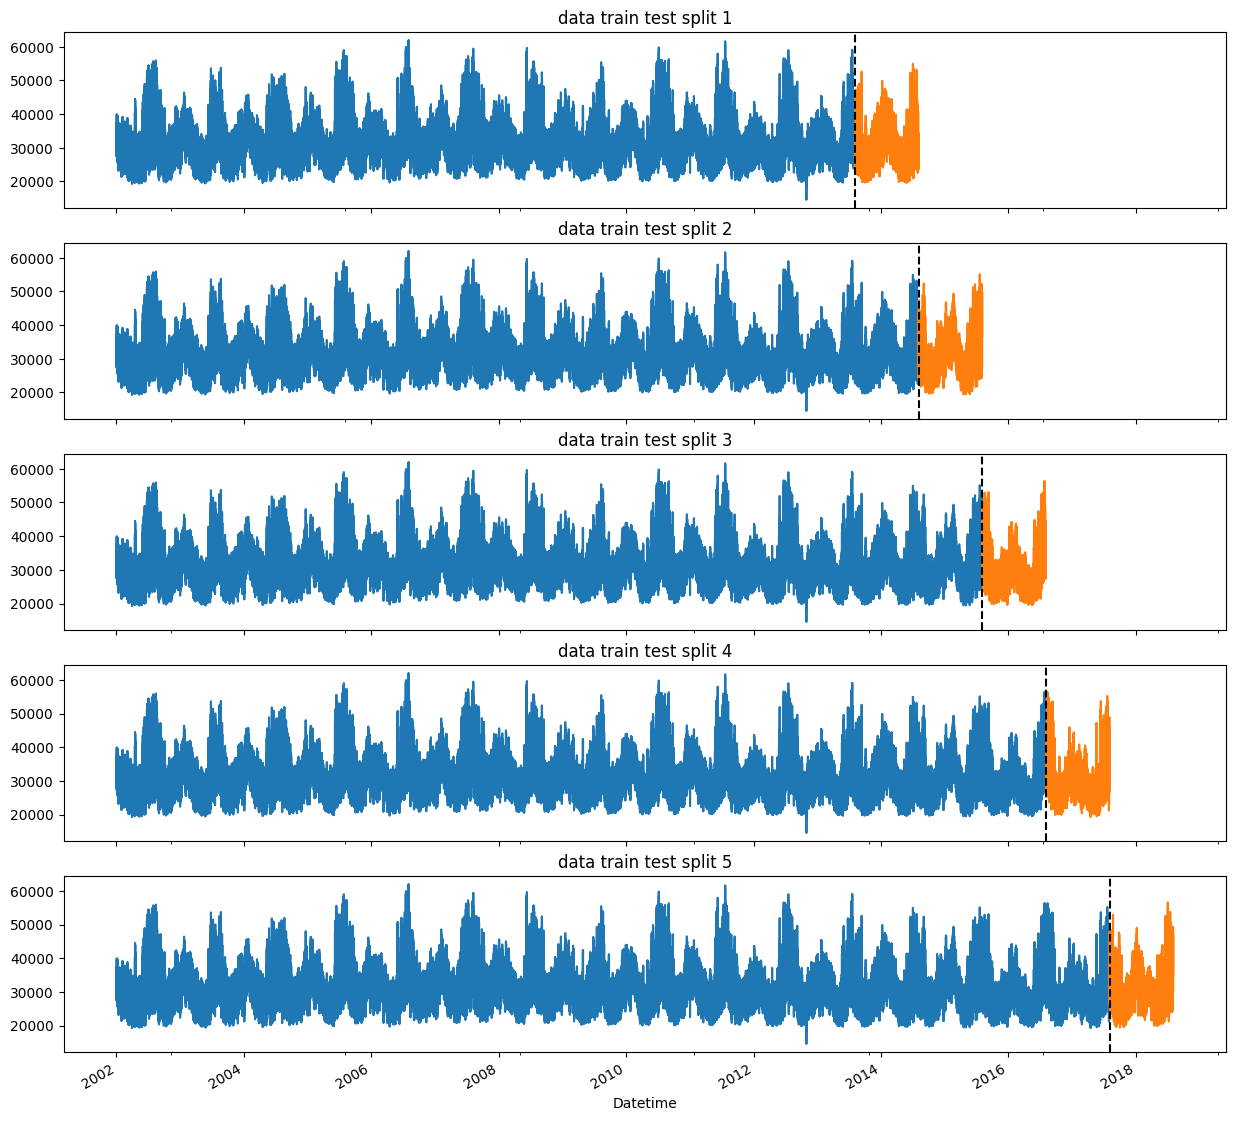

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['PJME_MW'].plot(ax=axs[fold], label='training', title=f'data train test split {fold + 1}')
    test['PJME_MW'].plot(ax=axs[fold], label='test set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

plt.show()


In [10]:
def create_features(df):
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df =  create_features(df)

In [11]:
target_map = df['PJME_MW'].to_dict()

In [12]:
def add_lags(df):
    df['lag1']= (df.index-pd.Timedelta('364 days')).map(target_map)
    df['lag2']= (df.index-pd.Timedelta('728 days')).map(target_map)
    df['lag3']= (df.index-pd.Timedelta('1092 days')).map(target_map)
    return df

In [13]:
df= add_lags(df)

In [14]:
from sklearn.metrics import mean_squared_error
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                           n_estimators=1000, 
                           early_stopping_rounds=50,
                           objective='reg:squarederror',  # Updated to 'reg:squarederror'
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    
    y_pred = reg.predict(X_test)  # Correct method to predict
    preds.append(y_pred)
    
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992
[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[472]	validation_0-rmse:3339.96200	validation_1-rmse:3766.70959
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280
[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	v

In [15]:
print(f'Scores across folds {np.mean(scores):0.4f}')
print(f' Fold scores :{scores}')

Scores across folds 3754.6872
 Fold scores :[np.float64(3758.5256000579657), np.float64(3423.147857410298), np.float64(3476.121686141068), np.float64(4111.027693505075), np.float64(4004.6130268714915)]


In [16]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'
X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                        n_estimators=500, 
                        objective='reg:squarederror', 
                        max_depth=3,
                        learning_rate=0.01)

# Corrected eval_set and verbose placement
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:32402.66145
[100]	validation_0-rmse:12426.65728
[200]	validation_0-rmse:5753.26464
[300]	validation_0-rmse:3973.71114
[400]	validation_0-rmse:3574.05442
[499]	validation_0-rmse:3459.67006


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [18]:
# Generate a future date range
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)

# Mark future data
future_df['isFuture'] = True
df['isFuture'] = False

# Combine the current data with the future data
df_and_future = pd.concat([df, future_df])

# Ensure the index is a DatetimeIndex
df_and_future.index = pd.to_datetime(df_and_future.index)

# Apply feature creation and lagging functions correctly
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [19]:
future_w_features = df_and_future.query('isFuture').copy()

In [21]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

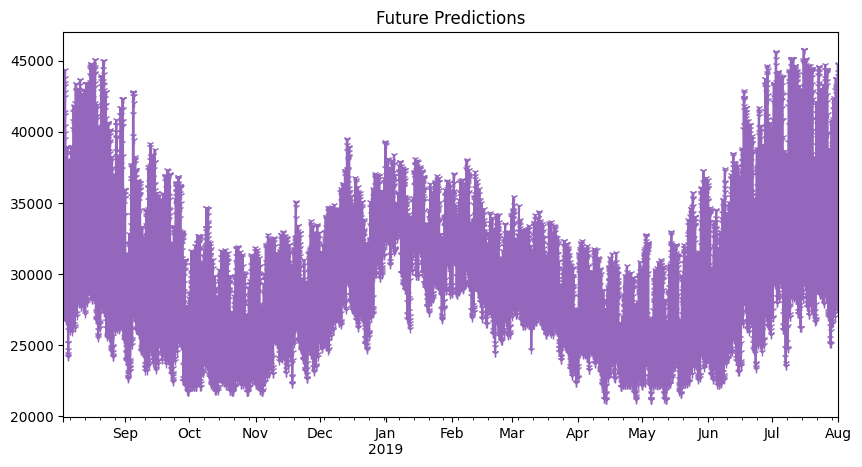

In [22]:
future_w_features['pred'].plot(figsize=(10, 5), color=color_pal[4], marker='1', linestyle='-', title='Future Predictions')


In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])